# Statistical Machine Learning
### **Exercise sheet 7**: Nadaraya-Watson, LOO CV, ROC, Precision and Recall

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

### ***Exercise 7.1***

##### (i)

We observe **training data**
$$
(x_1,y_1),\ldots,(x_n,y_n),
$$
where each $x_i\in\mathbb{R}$ is an input (predictor) and $y_i\in\mathbb{R}$ is an output (response).
We want an estimator $\hat f(x)$ that predicts $y$ at a new point $x$.

---
$K$ is a **kernel function**:
$$
K:\mathbb{R}\to[0,\infty).
$$
It's role is to turn a distance (how far $x$ is from $x_j$) into a **nonnegative weight**.
Typical assumptions:
- $K(u)\ge 0$ for all $u$,
- $K(u)$ is largest near $u=0$ and decreases as $|u|$ increases,
- often symmetric: $K(u)=K(-u)$.

A standard example (and what we use in code) is the **Gaussian kernel**:
$$
K(u)=\exp\!\left(-\frac{u^2}{2}\right).
$$
(Any constant normalizing factor is irrelevant here because NW divides by a sum of weights.)

---

$h>0$ is a **bandwidth (smoothing) parameter**.  
It rescales distances:
$$
u=\frac{x-x_j}{h}.
$$
- small $h$: only very close points get non-negligible weight (wiggly / low bias, high variance)
- large $h$: many points get similar weights (smooth / higher bias, lower variance)

---

For any evaluation point $x$, define **raw weights**
$$
w_j(x)=K\!\left(\frac{x-x_j}{h}\right).
$$
Then the **Nadaraya–Watson estimator** is the **weighted average** of the observed $y_j$’s:
$$
\hat f(x)=\frac{\sum_{j=1}^n w_j(x)\,y_j}{\sum_{j=1}^n w_j(x)}.
$$
Equivalently, define **normalized weights**
$$
\alpha_j(x)=\frac{w_j(x)}{\sum_{k=1}^n w_k(x)},
\qquad \text{so that }\alpha_j(x)\ge 0\text{ and }\sum_{j=1}^n \alpha_j(x)=1.
$$
Then
$$
\hat f(x)=\sum_{j=1}^n \alpha_j(x)\,y_j.
$$

---


Now evaluate the estimator at the **training inputs** $x=x_i$. Define:
$$
w_{ij}=K\!\left(\frac{x_i-x_j}{h}\right),
\qquad
d_i=\sum_{k=1}^n w_{ik}.
$$
The fitted value at $x_i$ is
$$
\hat y_i:=\hat f(x_i)=\frac{\sum_{j=1}^n w_{ij}y_j}{\sum_{j=1}^n w_{ij}}
=\sum_{j=1}^n \underbrace{\frac{w_{ij}}{d_i}}_{=:S_{ij}}\,y_j.
$$

So if we stack $\hat y=(\hat y_1,\ldots,\hat y_n)^\top$ and $y=(y_1,\ldots,y_n)^\top$, we obtain:
$$
\hat y = S\,y,
$$
where $S\in\mathbb{R}^{n\times n}$ has entries
$$
S_{ij}=\frac{K\!\left(\frac{x_i-x_j}{h}\right)}{\sum_{k=1}^n K\!\left(\frac{x_i-x_k}{h}\right)}.
$$

---

**Some key properties are:**
- $S_{ij}\ge 0$,
- each row sums to 1: $\sum_{j=1}^n S_{ij}=1$,
- $S_{ii}$ is the weight that point $i$ gives to its own response $y_i$ when predicting at $x_i$.




##### (ii)

We now generate $x\sim\mathcal N(0,4)$ (so $\text{sd}=2$), noise $\varepsilon\sim\mathcal N(0,0.25)$ (so $\text{sd}=0.5$), and
$$
y = x^2\cos(x) + \varepsilon.
$$

In [2]:
rng = np.random.default_rng(7)

n = 200
X = rng.normal(loc = 0.0, scale = 2.0, size = n)
eps = rng.normal(loc = 0.0, scale = .5, size = n)
Y = (X**2) * np.cos(X) + eps

##### (iii)

We now implement:
- a Gaussian kernel by default (we may swap kernels easily),
- prediction on a grid $x'\in[-10,10]$,
- multiple bandwidths $h$ for comparison.

In [4]:
def gaussian_kernel(u):
    # u can be array; returns elementwise exp(-u^2/2) (normalizing constant cancels in NW)
    return np.exp(-0.5 * u**2)

def nw_predict(x_eval, X, Y, h, kernel=gaussian_kernel, return_S=False):
    """
    Nadaraya–Watson prediction at points x_eval.

    Parameters
    ----------
    x_eval : (m,) array
    X : (n,) array
    Y : (n,) array
    h : float
    kernel : callable
    return_S : bool
        If True, also return the smoothing matrix S when x_eval == X and m==n.

    Returns
    -------
    y_hat : (m,) array
    (optional) S : (m,n) array of normalized weights
    """
    x_eval = np.asarray(x_eval).reshape(-1)
    X = np.asarray(X).reshape(-1)
    Y = np.asarray(Y).reshape(-1)

    # weight matrix W_{i,j} = K((x_eval_i - X_j)/h)
    U = (x_eval[:, None] - X[None, :]) / h
    W = kernel(U)

    denom = W.sum(axis=1, keepdims=True)
    # guard against division by zero (shouldn't happen for Gaussian, but safe)
    denom = np.where(denom == 0, 1e-12, denom)

    S = W / denom
    y_hat = S @ Y

    if return_S:
        return y_hat, S
    return y_hat

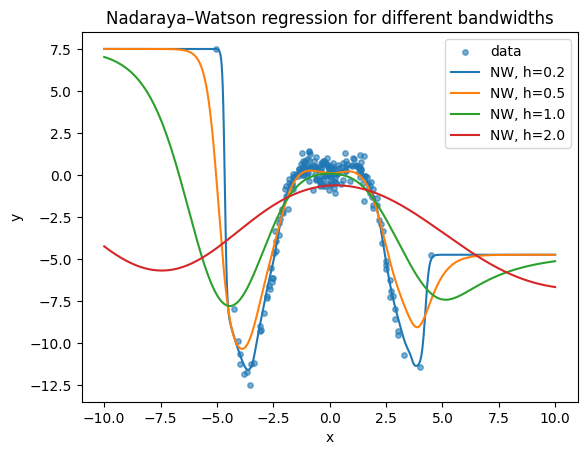

In [5]:
x_grid = np.linspace(-10, 10, 800)

bandwidths = [0.2, 0.5, 1.0, 2.0]  # experiment freely
plt.figure()
plt.scatter(X, Y, s=15, alpha=0.6, label="data")

for h in bandwidths:
    y_grid = nw_predict(x_grid, X, Y, h=h)
    plt.plot(x_grid, y_grid, label=f"NW, h={h}")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Nadaraya–Watson regression for different bandwidths")
plt.legend()
plt.show()


##### (iv)

Compute $\hat f_{-i}$ and verify
$$
y_i-\hat f_{-i}(x_i)=\frac{y_i-\hat f(x_i)}{1-S_{ii}}
$$

Because $\hat y = S y$, we have
$$
\hat f(x_i)=\sum_{j=1}^n S_{ij}y_j = S_{ii}y_i + \sum_{j\ne i}S_{ij}y_j.
$$
Let $d_i=\sum_{j=1}^n w_{ij}$ and $w_{ii}=K(0)$. The leave-one-out estimator at $x_i$ is
$$
\hat f_{-i}(x_i)=\frac{\sum_{j\ne i} w_{ij} y_j}{\sum_{j\ne i} w_{ij}}
=\frac{\sum_{j\ne i} w_{ij} y_j}{d_i-w_{ii}}.
$$
Using $S_{ii}=w_{ii}/d_i$ and $\sum_{j\ne i} w_{ij} y_j = d_i\hat f(x_i)-w_{ii}y_i$, we get
$$
\hat f_{-i}(x_i)=\frac{d_i\hat f(x_i)-w_{ii}y_i}{d_i-w_{ii}}.
$$
Then
$$
y_i-\hat f_{-i}(x_i)
= y_i-\frac{d_i\hat f(x_i)-w_{ii}y_i}{d_i-w_{ii}}
=\frac{d_i(y_i-\hat f(x_i))}{d_i-w_{ii}}
=\frac{y_i-\hat f(x_i)}{1-w_{ii}/d_i}
=\frac{y_i-\hat f(x_i)}{1-S_{ii}}.
$$
We will verify numerically.

In [6]:
def nw_loo_at_training_points(X, Y, h, kernel=gaussian_kernel):
    """
    Return:
    - y_hat: fitted values at X using all points
    - y_loo: LOO fitted values at each x_i leaving out (x_i, y_i)
    - S_diag: diagonal of smoothing matrix S (at training points)
    """
    y_hat, S = nw_predict(X, X, Y, h=h, kernel=kernel, return_S=True)
    S_diag = np.diag(S)

    # Direct LOO using weights excluding i:
    # y_loo_i = (sum_{j != i} w_{ij} y_j) / (sum_{j != i} w_{ij})
    # We can compute it from S, y_hat, and S_diag:
    # y_hat_i = S_ii y_i + sum_{j!=i} S_ij y_j
    # sum_{j!=i} S_ij y_j = y_hat_i - S_ii y_i
    # but note S_ij = w_ij / d_i with d_i = sum_j w_ij
    # LOO normalization uses d_i - w_ii => factor (1 - S_ii).
    y_loo = (y_hat - S_diag * Y) / np.clip(1.0 - S_diag, 1e-12, None)

    return y_hat, y_loo, S_diag

h_test = 0.5
y_hat, y_loo, S_diag = nw_loo_at_training_points(X, Y, h=h_test)

lhs = Y - y_loo
rhs = (Y - y_hat) / np.clip(1.0 - S_diag, 1e-12, None)

max_abs_diff = np.max(np.abs(lhs - rhs))
print("Max |(y_i - f_-i(x_i)) - (y_i - f(x_i))/(1-S_ii)| =", max_abs_diff)
# Should be very close to zero if correct

Max |(y_i - f_-i(x_i)) - (y_i - f(x_i))/(1-S_ii)| = 1.7763568394002505e-15


close enough

##### (v)

**Choosing the bandwidth $h$**

A standard, principled choice is **leave-one-out cross-validation (LOO-CV)**:
$$
\text{CV}(h)=\frac1n\sum_{i=1}^n\left(y_i-\hat f_{-i,h}(x_i)\right)^2,
$$
and pick $h$ minimizing $\text{CV}(h)$ over a grid of candidate values.

With the identity in (d), we can compute this efficiently using the smoothing matrix diagonal:
$$
y_i-\hat f_{-i}(x_i)=\frac{y_i-\hat f(x_i)}{1-S_{ii}},
\quad\Rightarrow\quad
\text{CV}(h)=\frac1n\sum_{i=1}^n\left(\frac{y_i-\hat f(x_i)}{1-S_{ii}}\right)^2.
$$

Selected h* = 0.0650967523045817
Min LOO-CV MSE = 0.9903771846316057


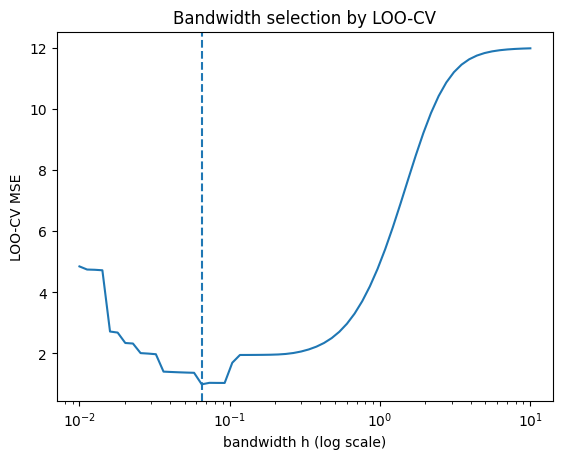

In [7]:
def loo_cv_mse(X, Y, h, kernel=gaussian_kernel):
    y_hat, y_loo, S_diag = nw_loo_at_training_points(X, Y, h=h, kernel=kernel)
    return np.mean((Y - y_loo)**2)

h_grid = np.logspace(-2, 1, 60)  # from 0.01 to 10
cv_scores = np.array([loo_cv_mse(X, Y, h) for h in h_grid])

h_star = h_grid[np.argmin(cv_scores)]
print("Selected h* =", h_star)
print("Min LOO-CV MSE =", cv_scores.min())

plt.figure()
plt.semilogx(h_grid, cv_scores)
plt.axvline(h_star, linestyle="--")
plt.xlabel("bandwidth h (log scale)")
plt.ylabel("LOO-CV MSE")
plt.title("Bandwidth selection by LOO-CV")
plt.show()

##### (vi)

Plot with chosen $h$ and check reasonableness

We will:
1. compute CV over a grid of $h$’s,
2. select $h^{*}$,
3. plot predictions $\hat f_{h^{*}}(x')$ and the raw data,
4. optionally overlay a couple nearby bandwidths to see under/over-smoothing.


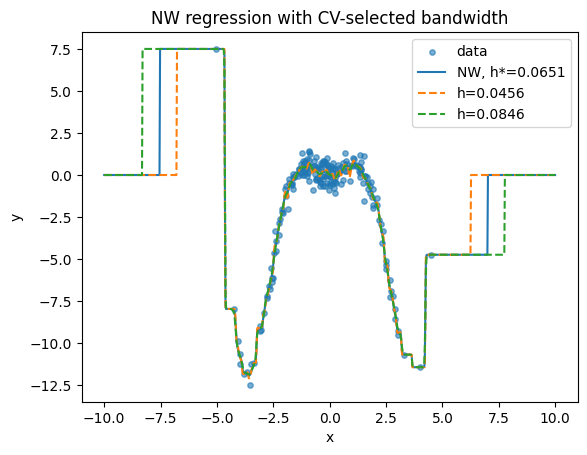

In [8]:
plt.figure()
plt.scatter(X, Y, s=15, alpha=0.6, label="data")

y_star = nw_predict(x_grid, X, Y, h=h_star)
plt.plot(x_grid, y_star, label=f"NW, h*={h_star:.3g}")

# optional: show nearby bandwidths to visually compare smoothness
for factor in [0.7, 1.3]:
    h_alt = h_star * factor
    y_alt = nw_predict(x_grid, X, Y, h=h_alt)
    plt.plot(x_grid, y_alt, linestyle="--", label=f"h={h_alt:.3g}")

plt.xlabel("x")
plt.ylabel("y")
plt.title("NW regression with CV-selected bandwidth")
plt.legend()
plt.show()


### ***Exercise 7.2***

In this exercise we adapt the **Nadaraya–Watson (NW)** estimator from regression to **binary classification**, and evaluate it using standard classification metrics.

Throughout, we reuse the data-generating mechanism from Exercise 7.1.

##### (i)

**How to adapt the NW estimator to binary classification**

Assume the response variable takes values in $\{0,1\}$.
For any input $x$, the conditional expectation
$$
\mathbb{E}[Y \mid X=x] = \mathbb{P}(Y=1 \mid X=x)
$$
is exactly the **class-1 probability**.

The NW estimator estimates this conditional expectation as
$$
\hat f(x)
= \sum_{i=1}^n w_i(x)\, y_i,
\qquad
w_i(x)=\frac{K\!\left(\frac{x-x_i}{h}\right)}{\sum_{j=1}^n K\!\left(\frac{x-x_j}{h}\right)}.
$$

To obtain a **classifier**, we use a **plug-in rule** with threshold $1/2$:
$$
\hat g(x)=
\begin{cases}
1 & \text{if } \hat f(x) > \tfrac12, \\
0 & \text{otherwise}.
\end{cases}
$$

Thus:
- NW estimates probabilities,
- classification is done by thresholding those probabilities.


##### (ii)

**Generate binary labels from simulated data**

From Exercise 7.1 we have continuous responses
$$
y = x^2\cos(x)+\varepsilon.
$$

Define binary labels via a logistic transform:
$$
z = \mathbf{1}\!\left\{ \frac{1}{1+e^{-y}} > 0.5 \right\}.
$$

Since $\frac{1}{1+e^{-y}}>0.5 \iff y>0$, this is equivalent to
$$
z=\mathbf{1}\{y>0\}.
$$

So the classification problem is: predict whether the latent signal $y$ is positive or negative, using $x$.


In [9]:
Z = (Y > 0).astype(int)

##### (iii)

**Confusion matrix for $h=0.2$**

Fix the bandwidth $h=0.2$.
Compute:
- estimated probabilities $\hat f(x_i)$,
- predicted labels $\hat z_i = \mathbf{1}\{\hat f(x_i)>0.5\}$,
- the confusion matrix.

In [10]:
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2)

def nw_prob(x_eval, X, Z, h):
    U = (x_eval[:, None] - X[None, :]) / h
    W = gaussian_kernel(U)
    W /= W.sum(axis=1, keepdims=True)
    return W @ Z


In [12]:
h = 0.2
probs = nw_prob(X, X, Z, h)
Z_hat = (probs > 0.5).astype(int)

cm = confusion_matrix(Z, Z_hat)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[86 29]
 [13 72]]


##### (iv)

**Misclassification rate, precision, recall**

Given the confusion matrix:
- **Misclassification rate**
$$
\frac{FP+FN}{n}
$$
- **Precision**
$$
\text{Precision}=\frac{TP}{TP+FP}
$$
- **Recall**
$$
\text{Recall}=\frac{TP}{TP+FN}.
$$

In [13]:
misclassification_rate = np.mean(Z_hat != Z)
precision = precision_score(Z, Z_hat)
recall = recall_score(Z, Z_hat)

print("Misclassification rate:", misclassification_rate)
print("Precision:", precision)
print("Recall:", recall)

Misclassification rate: 0.21
Precision: 0.7128712871287128
Recall: 0.8470588235294118


##### (v)

**ROC curve and AUC**

Instead of fixing the threshold at $0.5$, vary it in $[0,1]$.
For each threshold:
- compute True Positive Rate (TPR),
- compute False Positive Rate (FPR).

The **ROC curve** plots TPR vs FPR.
The **AUC** (area under the curve) summarizes overall ranking quality.

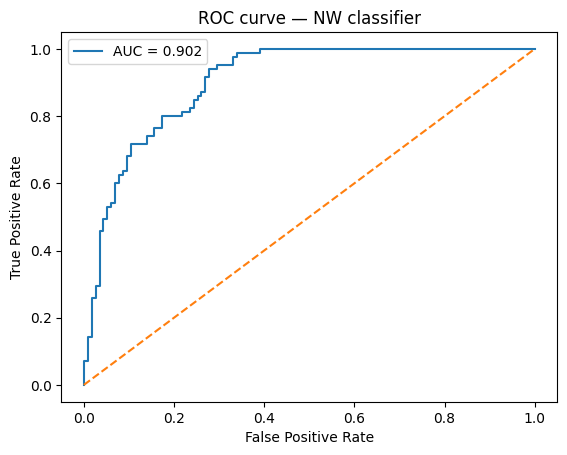

In [14]:
fpr, tpr, thresholds = roc_curve(Z, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve — NW classifier")
plt.legend()
plt.show()

##### (vi)

**Achieving a false positive rate of 20%**

To enforce a **false positive rate (FPR) of 20%**:
- do **not** change the bandwidth,
- **lower or raise the classification threshold** until FPR $\approx 0.2$.

This corresponds to selecting a point on the ROC curve with FPR = 0.2.

In [15]:
idx = np.argmin(np.abs(fpr - 0.2))
threshold_20 = thresholds[idx]
print("Threshold for FPR ≈ 0.2:", threshold_20)

Threshold for FPR ≈ 0.2: 0.5119932602848063


##### (vii)

**Unequal costs: false positives cost 4× false negatives**

*Example setting*
Medical screening:
- False positive → unnecessary expensive follow-up
- False negative → missed disease (less costly at this stage)

- *Does 0–1 loss still make sense?*
No. The misclassification rate treats FP and FN equally, which contradicts the cost structure.

- *Sensible cost function*
Let:
- $C_{FP}=4$,
- $C_{FN}=1$.

Expected cost:
$$
\text{Risk} = 4\,\mathbb{P}(\text{FP}) + 1\,\mathbb{P}(\text{FN}).
$$

- *How to adapt the classifier*
Change the plug-in threshold:
$$
\hat g(x)=\mathbf{1}\{\hat f(x)>\tau\},
\qquad
\tau=\frac{C_{FP}}{C_{FP}+C_{FN}}=\frac{4}{5}=0.8.
$$

So the decision boundary shifts upward to reduce false positives.

In [16]:
tau = 4 / (4 + 1)
Z_cost = (probs > tau).astype(int)

cm_cost = confusion_matrix(Z, Z_cost)
print("Cost-sensitive confusion matrix:\n", cm_cost)


Cost-sensitive confusion matrix:
 [[111   4]
 [ 54  31]]


##### (viii)

Choosing the bandwidth with cost-sensitive loss

Instead of minimizing misclassification error or standard CV:
1. For each candidate bandwidth $h$,
2. For each threshold $\tau$ (or directly using ROC),
3. Compute the **empirical cost**
$$
\widehat{\text{Risk}}(h)
= 4\,\widehat{\mathbb{P}}(\text{FP}) + \widehat{\mathbb{P}}(\text{FN}),
$$
4. Select $h$ minimizing this cost.

This mirrors Exercise 7.2(f):  
**bandwidth controls smoothness, threshold controls operating point**.